In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [99]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA


In [100]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26966 entries, 0 to 26965
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26966 non-null  datetime64[ns]
 1   Open       26966 non-null  float64       
 2   High       26966 non-null  float64       
 3   Low        26966 non-null  float64       
 4   Close      26966 non-null  float64       
 5   Adj Close  26966 non-null  float64       
 6   Volume     26966 non-null  int64         
 7   Ticker     26966 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [101]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998


In [102]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.80
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 30
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA,-0.026404,0.499759,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA,-0.013185,0.484986,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA,0.003296,0.484668,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA,0.009889,0.492516,1.0


In [103]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 30
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.267754,227,ABEV3.SA,-0.026404,0.499759,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.260614,1137,ABEV3.SA,-0.013185,0.484986,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.262399,606,ABEV3.SA,0.003296,0.484668,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.267754,6445,ABEV3.SA,0.009889,0.492516,1.0,0.494478,1.0


In [104]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_30'] = price_data.groupby('Ticker')['Close'].shift(-30)
price_data['Smoothed_Close_30'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-30)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [105]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.282051,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.599993,0.600635
5705,2024-11-18,12.480000,12.670000,12.380000,12.420000,11.771206,37251000,ABEV3.SA,-0.220000,12.466244,NaN,12.420000,NaN,NaN,NaN
5706,2024-11-19,12.450000,12.600000,12.420000,12.430000,11.780684,28564100,ABEV3.SA,0.010000,12.437249,NaN,12.430000,NaN,NaN,NaN
5707,2024-11-21,12.310000,12.480000,12.300000,12.390000,11.742773,18400700,ABEV3.SA,-0.040000,12.399450,NaN,12.390000,NaN,NaN,NaN
5708,2024-11-22,12.490000,12.700000,12.470000,12.680000,12.017624,24116600,ABEV3.SA,0.290000,12.623890,NaN,12.680000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [106]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [107]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,23.820162
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,21.207187
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,18.468819
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,14.968095
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,8.582397


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [108]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,23.820162,-76.179838
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,21.207187,-78.792813
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,18.468819,-81.531181
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,14.968095,-85.031905
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,8.582397,-91.417603


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [109]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,23.820162,-76.179838,-1.199513,-0.975599
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,21.207187,-78.792813,-1.197522,-1.019984
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,18.468819,-81.531181,-1.197300,-1.055447
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,14.968095,-85.031905,-1.205625,-1.085483
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,8.582397,-91.417603,-1.267292,-1.121844


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [110]:
# Período do indicador
n = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,23.820162,-76.179838,-1.199513,-0.975599,-0.068496
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,21.207187,-78.792813,-1.197522,-1.019984,-0.041707
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,18.468819,-81.531181,-1.197300,-1.055447,-0.027171
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,14.968095,-85.031905,-1.205625,-1.085483,-0.028073
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,8.582397,-91.417603,-1.267292,-1.121844,-0.046549


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [111]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11747,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,54.964064,NaN,55.009998,NaN,NaN,NaN,0.000000,0.16,38.934135,53.330002,60.189999,23.820162,-76.179838,-1.199513,-0.975599,-0.068496,-998674742
11748,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,54.784814,NaN,54.740002,NaN,NaN,NaN,0.269997,0.00,36.806222,53.330002,60.189999,21.207187,-78.792813,-1.197522,-1.019984,-0.041707,-1015310042
11749,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,54.596962,NaN,54.549999,NaN,NaN,NaN,0.190002,0.00,35.242227,53.330002,60.189999,18.468819,-81.531181,-1.197300,-1.055447,-0.027171,-1026560942
11750,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.319392,NaN,54.250000,NaN,NaN,NaN,0.299999,0.00,32.709994,53.330002,59.939999,14.968095,-85.031905,-1.205625,-1.085483,-0.028073,-1044184842
11751,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.455880,NaN,53.240002,NaN,NaN,NaN,1.009998,0.00,25.572295,52.880001,59.590000,8.582397,-91.417603,-1.267292,-1.121844,-0.046549,-1067793542


#### Salvando antes de tirar os Nans.

In [112]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D30.parquet', index=False)

In [113]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D30.xlsx', index=False)

## Removendo Nans

In [114]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 26966 linhas e 26 colunas
Depois da retirada dos NaN temos 26751 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.262759,75,ABEV3.SA,-0.029034,0.490611,1.0,0.485255,1.0,0.586808,0.587293,0.029034,0.000000,43.244009,0.468107,0.527474,37.905880,-62.094120,-0.000278,-0.000366,-0.003869,28136
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.267754,455,ABEV3.SA,0.009223,0.493705,1.0,0.494478,1.0,0.606585,0.602727,0.000000,0.009223,47.299662,0.468107,0.527474,43.117397,-56.882603,-0.000554,-0.000405,-0.051448,28591
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.264184,5005,ABEV3.SA,-0.006593,0.489049,1.0,0.487885,1.0,0.599993,0.600540,0.006593,0.000000,44.667003,0.468107,0.527474,35.275314,-64.724686,-0.001039,-0.000535,-0.065700,23586
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.257044,3033,ABEV3.SA,-0.013185,0.477570,1.0,0.474700,1.0,0.626363,0.621198,0.013185,0.000000,39.583155,0.468107,0.527474,15.939449,-84.060551,-0.002106,-0.000857,-0.055385,20553
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.253474,11602,ABEV3.SA,-0.006593,0.470000,1.0,0.468107,1.0,0.652734,0.646427,0.006593,0.000000,37.143972,0.468107,0.527474,3.187890,-96.812110,-0.003375,-0.001370,-0.011775,8951


## VALIDAÇÃO

### Geral

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [115]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  72.32356459330144


In [116]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 91.79%


In [117]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [118]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.262759,75,ABEV3.SA,-0.029034,0.490611,1.0,0.485255,1.0,0.586808,0.587293,0.029034,0.000000,43.244009,0.468107,0.527474,37.905880,-62.094120,-0.000278,-0.000366,-0.003869,28136,1
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.267754,455,ABEV3.SA,0.009223,0.493705,1.0,0.494478,1.0,0.606585,0.602727,0.000000,0.009223,47.299662,0.468107,0.527474,43.117397,-56.882603,-0.000554,-0.000405,-0.051448,28591,1
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.264184,5005,ABEV3.SA,-0.006593,0.489049,1.0,0.487885,1.0,0.599993,0.600540,0.006593,0.000000,44.667003,0.468107,0.527474,35.275314,-64.724686,-0.001039,-0.000535,-0.065700,23586,1
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.257044,3033,ABEV3.SA,-0.013185,0.477570,1.0,0.474700,1.0,0.626363,0.621198,0.013185,0.000000,39.583155,0.468107,0.527474,15.939449,-84.060551,-0.002106,-0.000857,-0.055385,20553,1
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.253474,11602,ABEV3.SA,-0.006593,0.470000,1.0,0.468107,1.0,0.652734,0.646427,0.006593,0.000000,37.143972,0.468107,0.527474,3.187890,-96.812110,-0.003375,-0.001370,-0.011775,8951,1


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [119]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.57
Fold 2:
  Accuracy with Y_test (Prediction): 0.38
  Accuracy with Verify: 0.39
Fold 3:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.55
Fold 4:
  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.59
Fold 5:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.53

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.54
  Média da acurácia com Verify: 0.52


#### Plotagem Time-Series Cross Validation

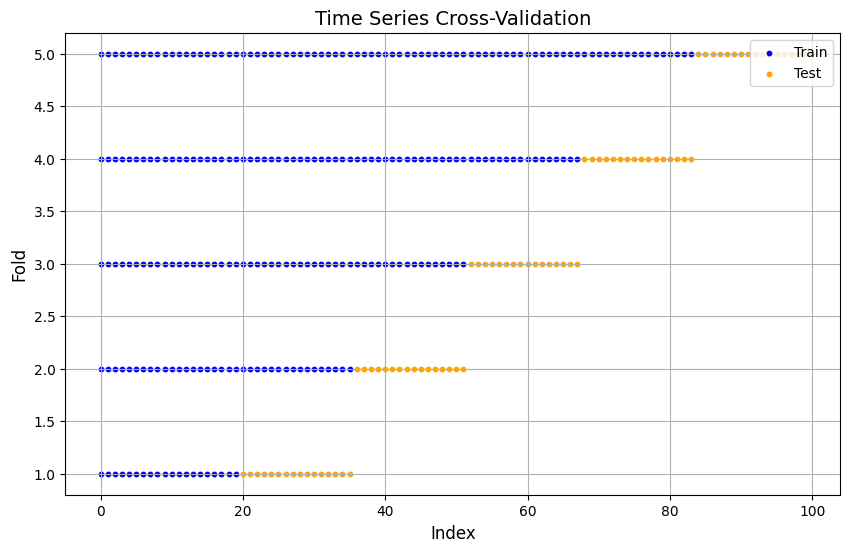

In [135]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_ABEV):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [120]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [121]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.66
Window 2:
  Accuracy with Y_test (Prediction): 0.36
  Accuracy with Verify: 0.34
Window 3:
  Accuracy with Y_test (Prediction): 0.74
  Accuracy with Verify: 0.71
Window 4:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.50
Window 5:
  Accuracy with Y_test (Prediction): 0.78
  Accuracy with Verify: 0.74
Window 6:
  Accuracy with Y_test (Prediction): 0.84
  Accuracy with Verify: 0.83
Window 7:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.48
Window 8:
  Accuracy with Y_test (Prediction): 0.34
  Accuracy with Verify: 0.31
Window 9:
  Accuracy with Y_test (Prediction): 0.29
  Accuracy with Verify: 0.27
Window 10:
  Accuracy with Y_test (Prediction): 0.50
  Accuracy with Verify: 0.51
Window 11:
  Accuracy with Y_test (Prediction): 0.35
  Accuracy with Verify: 0.38
Window 12:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.58
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [122]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,1.000000,0.032258,0.062500,124.000000
Up Day,0.318182,1.000000,0.482759,56.000000
accuracy,0.333333,0.333333,0.333333,0.333333
macro avg,0.659091,0.516129,0.272629,180.000000
weighted avg,0.787879,0.333333,0.193247,180.000000


Accuracy: 0.3333333333333333
Precision: 0.3181818181818182
Recall: 1.0
Specificity: 0.03225806451612903


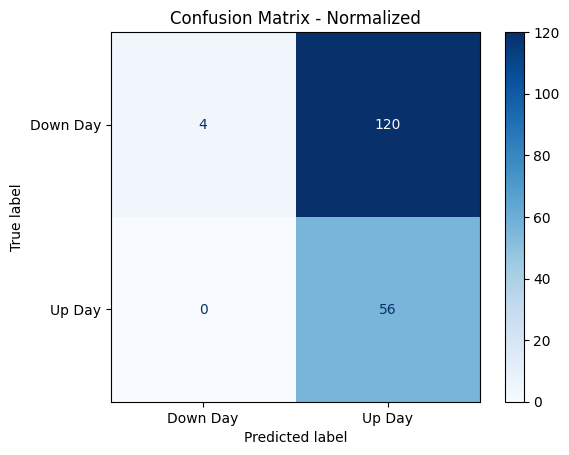

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


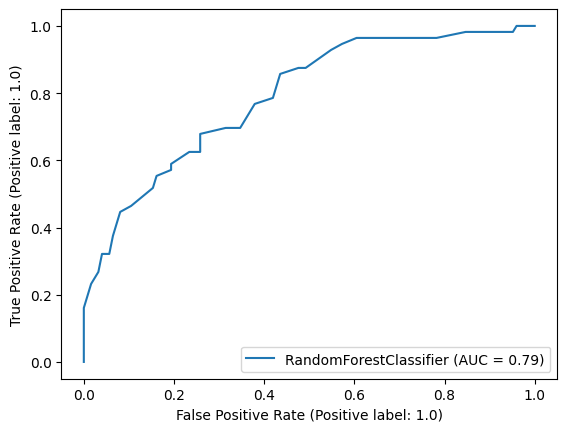

In [124]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Split normal sem cross-validation.

In [125]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [126]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  79.2691496837667


In [127]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.737778,0.652259,0.692388,509.000000
Up Day,0.818088,0.870897,0.843667,914.000000
accuracy,0.792691,0.792691,0.792691,0.792691
macro avg,0.777933,0.761578,0.768028,1423.000000
weighted avg,0.789362,0.792691,0.789555,1423.000000


#### Salvar modelo aprendido para AMBEV.

In [128]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [129]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 87.81%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

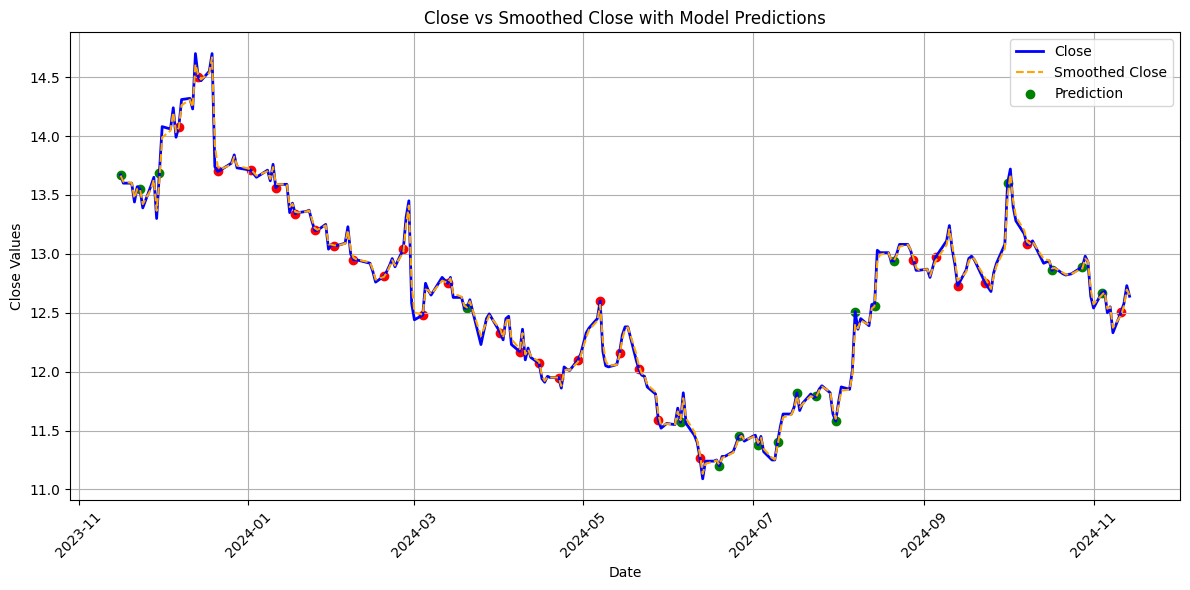

In [130]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 5):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [131]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17830,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.682505,49788916,ITUB4.SA,-0.049343,3.089410,-1.0,3.080100,-1.0,2.823122,2.845145,0.049343,0.000000,54.433299,2.790006,3.228790,68.235006,-31.764994,0.021837,0.010762,0.018791,395485672,1
17831,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.700415,7959945,ITUB4.SA,0.032785,3.108190,-1.0,3.112885,-1.0,2.906077,2.893891,0.000000,0.032785,59.382961,2.790006,3.228790,72.514961,-27.485039,0.021464,0.012903,0.043866,403445617,1
17832,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.709460,26138577,ITUB4.SA,0.016558,3.125192,-1.0,3.129443,-1.0,2.996814,2.976229,0.000000,0.016558,61.800980,2.790006,3.228790,76.389827,-23.610173,0.021942,0.014710,0.021484,429584194,1
17833,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.723027,52977726,ITUB4.SA,0.024837,3.148462,-1.0,3.154280,-1.0,2.963864,2.966337,0.000000,0.024837,65.369227,2.831401,3.228790,79.786147,-20.213853,0.023474,0.016463,0.010597,482561920,1
17834,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.781816,141660459,ITUB4.SA,0.107626,3.239217,-1.0,3.261906,-1.0,3.013538,3.004098,0.000000,0.107626,76.394363,2.864351,3.261906,94.292940,-5.707060,0.030082,0.019187,0.031678,624222379,1


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [132]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.54
Fold 2:
  Accuracy with Y_test (Prediction): 0.65
  Accuracy with Verify: 0.62
Fold 3:
  Accuracy with Y_test (Prediction): 0.63
  Accuracy with Verify: 0.60
Fold 4:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.55
Fold 5:
  Accuracy with Y_test (Prediction): 0.65
  Accuracy with Verify: 0.61

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.62
  Média da acurácia com Verify: 0.58

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0    -1.0
3            1.0              1.0    -1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4815        -1.0             -1.0    -1.0
4816        -1.0             -1.0    -1.0
4817        -1.0             -1.0    -1.0
4818         1.0              1.0    -1.0
4819         1.0    

#### Plotagem Time-Series Cross Validation

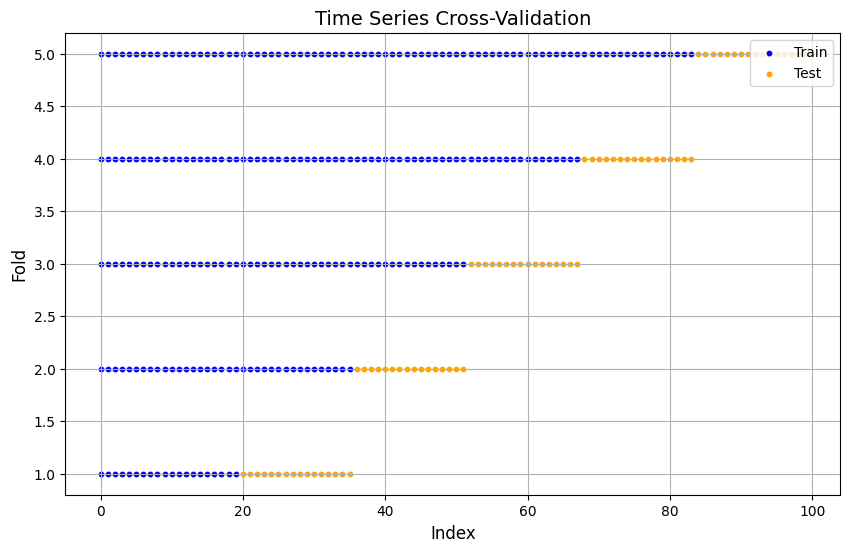

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Itau):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [133]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [134]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.50
  Accuracy with Verify: 0.49
Window 2:
  Accuracy with Y_test (Prediction): 0.33
  Accuracy with Verify: 0.33
Window 3:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.47
Window 4:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.73
Window 5:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.67
Window 6:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.63
Window 7:
  Accuracy with Y_test (Prediction): 0.36
  Accuracy with Verify: 0.32
Window 8:
  Accuracy with Y_test (Prediction): 0.55
  Accuracy with Verify: 0.53
Window 9:
  Accuracy with Y_test (Prediction): 0.64
  Accuracy with Verify: 0.60
Window 10:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.70
Window 11:
  Accuracy with Y_test (Prediction): 0.55
  Accuracy with Verify: 0.50
Window 12:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.58
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [135]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.443038,0.330189,0.378378,106.000000
Up Day,0.297030,0.405405,0.342857,74.000000
accuracy,0.361111,0.361111,0.361111,0.361111
macro avg,0.370034,0.367797,0.360618,180.000000
weighted avg,0.383012,0.361111,0.363775,180.000000


Accuracy: 0.3611111111111111
Precision: 0.297029702970297
Recall: 0.40540540540540543
Specificity: 0.330188679245283


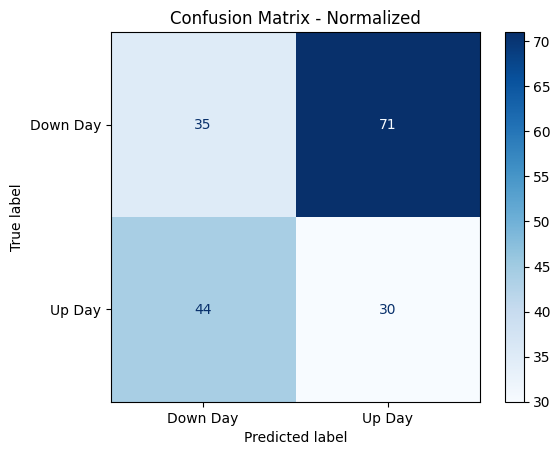

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


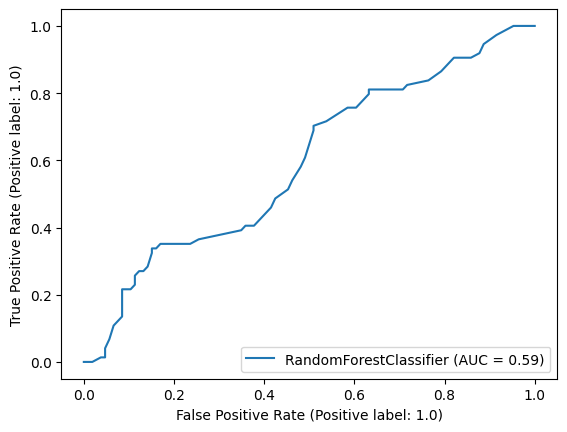

In [137]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Split normal sem cross-validation.

In [138]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  74.91361437456807


In [139]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.716141,0.647651,0.680176,596.000000
Up Day,0.768722,0.820212,0.793633,851.000000
accuracy,0.749136,0.749136,0.749136,0.749136
macro avg,0.742432,0.733931,0.736904,1447.000000
weighted avg,0.747065,0.749136,0.746902,1447.000000


#### Salvar modelo aprendido para ITAU.

In [140]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [141]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 85.73%

Precisão do modelo nos últimos 30 dias: 60.87%


#### Plotagem:

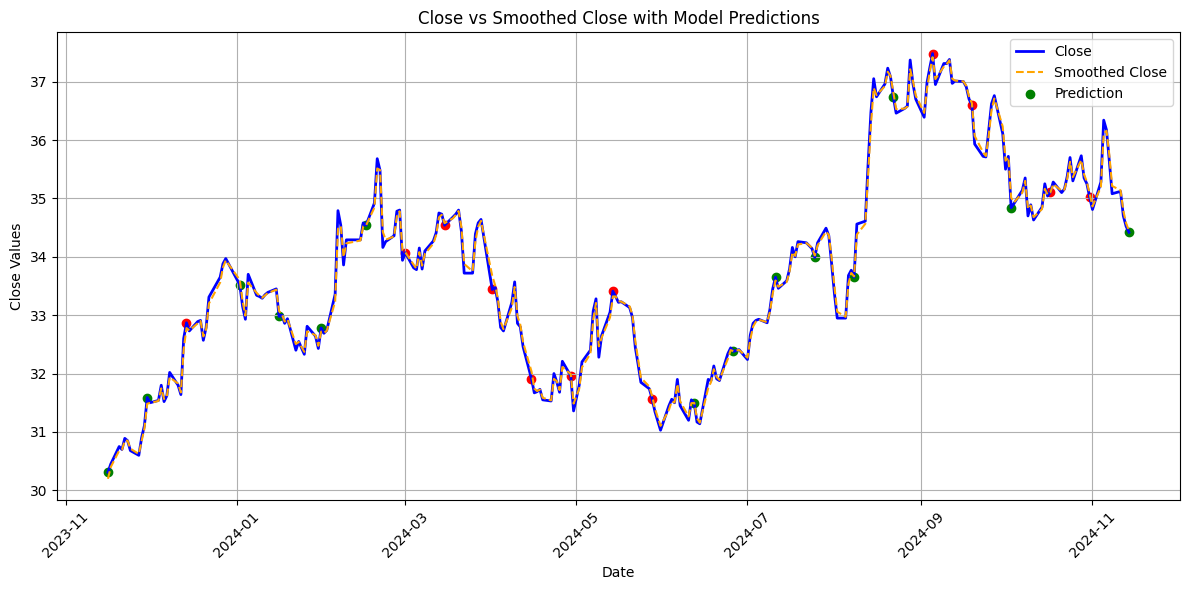

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [143]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23661,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274924,935719,MGLU3.SA,-0.017537,4.643858,1.0,4.641542,1.0,4.901678,4.877886,0.017537,0.000000,32.626397,4.533395,4.878295,32.027546,-67.972454,-0.019128,-0.046630,-0.024491,-10963360,1
23662,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218390,3585840,MGLU3.SA,-0.061381,4.592900,1.0,4.580161,1.0,4.881218,4.880552,0.061381,0.000000,25.316822,4.533395,4.878295,17.253004,-82.746996,-0.023380,-0.041980,-0.026260,-14549200,1
23663,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091866,1985366,MGLU3.SA,-0.137376,4.472808,1.0,4.442785,1.0,4.793532,4.810936,0.137376,0.000000,16.037903,4.439862,4.822760,8.604411,-91.395589,-0.033596,-0.040303,-0.063909,-16534566,1
23664,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234543,1263135,MGLU3.SA,0.154913,4.572720,1.0,4.597698,1.0,4.764303,4.773630,0.000000,0.154913,43.149183,4.436940,4.822760,35.192574,-64.807426,-0.034788,-0.039200,-0.046384,-15271431,1
23665,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.609070,-1.0,4.618158,-1.0,4.545086,4.590795,0.000000,0.020460,45.815425,4.436940,4.822760,44.614112,-55.385888,-0.032981,-0.037956,-0.036195,-13493394,1


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [144]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.49
Fold 2:
  Accuracy with Y_test (Prediction): 0.32
  Accuracy with Verify: 0.32
Fold 3:
  Accuracy with Y_test (Prediction): 0.70
  Accuracy with Verify: 0.70
Fold 4:
  Accuracy with Y_test (Prediction): 0.50
  Accuracy with Verify: 0.49
Fold 5:
  Accuracy with Y_test (Prediction): 0.43
  Accuracy with Verify: 0.38

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.49
  Média da acurácia com Verify: 0.48

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0             -1.0     1.0
3           -1.0             -1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
2720        -1.0             -1.0    -1.0
2721        -1.0             -1.0    -1.0
2722         1.0             -1.0    -1.0
2723         1.0             -1.0    -1.0
2724         1.0    

#### Plotagem Time-Series Cross Validation

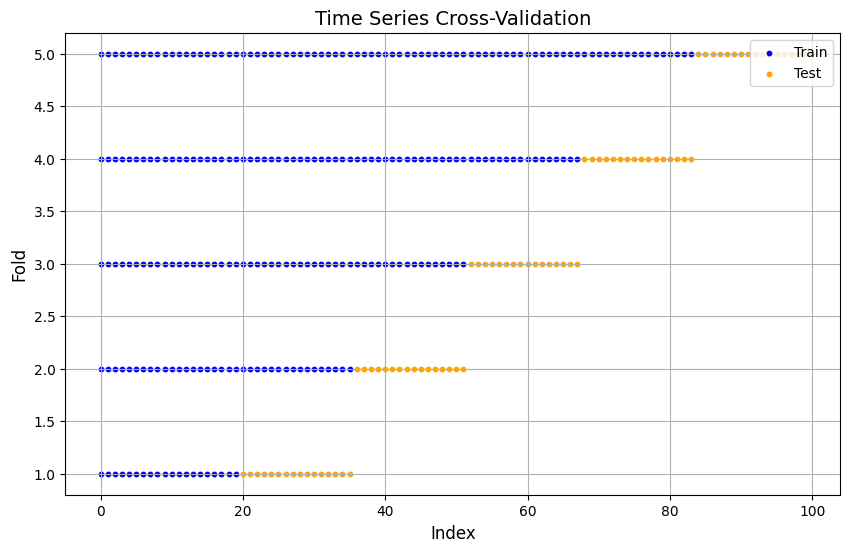

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Magalu):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [145]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [146]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.49
Window 2:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.72
Window 3:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.58
Window 4:
  Accuracy with Y_test (Prediction): 0.12
  Accuracy with Verify: 0.12
Window 5:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.54
Window 6:
  Accuracy with Y_test (Prediction): 0.87
  Accuracy with Verify: 0.87
Window 7:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.57
Window 8:
  Accuracy with Y_test (Prediction): 0.85
  Accuracy with Verify: 0.83
Window 9:
  Accuracy with Y_test (Prediction): 0.67
  Accuracy with Verify: 0.68
Window 10:
  Accuracy with Y_test (Prediction): 0.75
  Accuracy with Verify: 0.78
Window 11:
  Accuracy with Y_test (Prediction): 0.28
  Accuracy with Verify: 0.27
Window 12:
  Accuracy with Y_test (Prediction): 0.28
  Accuracy with Verify: 0.24
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [147]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.545455,0.188976,0.280702,127.000000
Up Day,0.242647,0.622642,0.349206,53.000000
accuracy,0.316667,0.316667,0.316667,0.316667
macro avg,0.394051,0.405809,0.314954,180.000000
weighted avg,0.456295,0.316667,0.300873,180.000000


Accuracy: 0.31666666666666665
Precision: 0.2426470588235294
Recall: 0.6226415094339622
Specificity: 0.1889763779527559


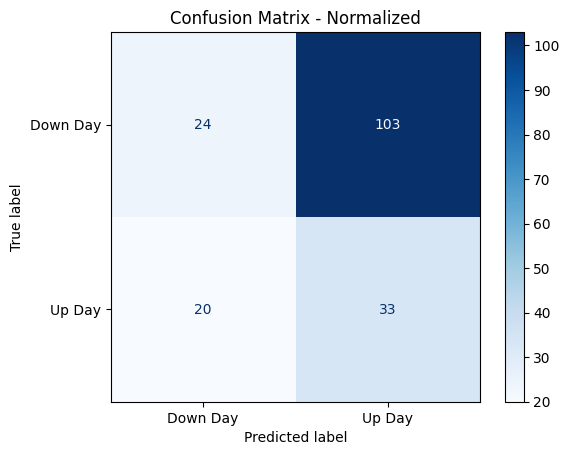

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


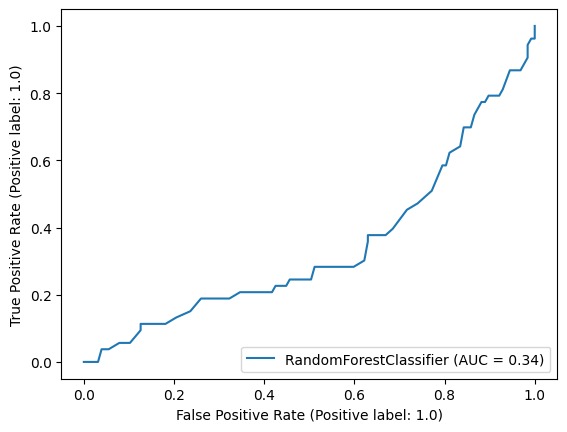

In [149]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


#### Split normal sem cross-validation.

In [150]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [151]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  81.07448107448107


In [152]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.790885,0.793011,0.791946,372.000000
Up Day,0.827354,0.825503,0.826428,447.000000
accuracy,0.810745,0.810745,0.810745,0.810745
macro avg,0.809119,0.809257,0.809187,819.000000
weighted avg,0.810789,0.810745,0.810766,819.000000


#### Salvar modelo aprendido para MAGALU.

In [153]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [154]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 90.02%

Precisão do modelo nos últimos 30 dias: 95.45%


#### Plotagem:

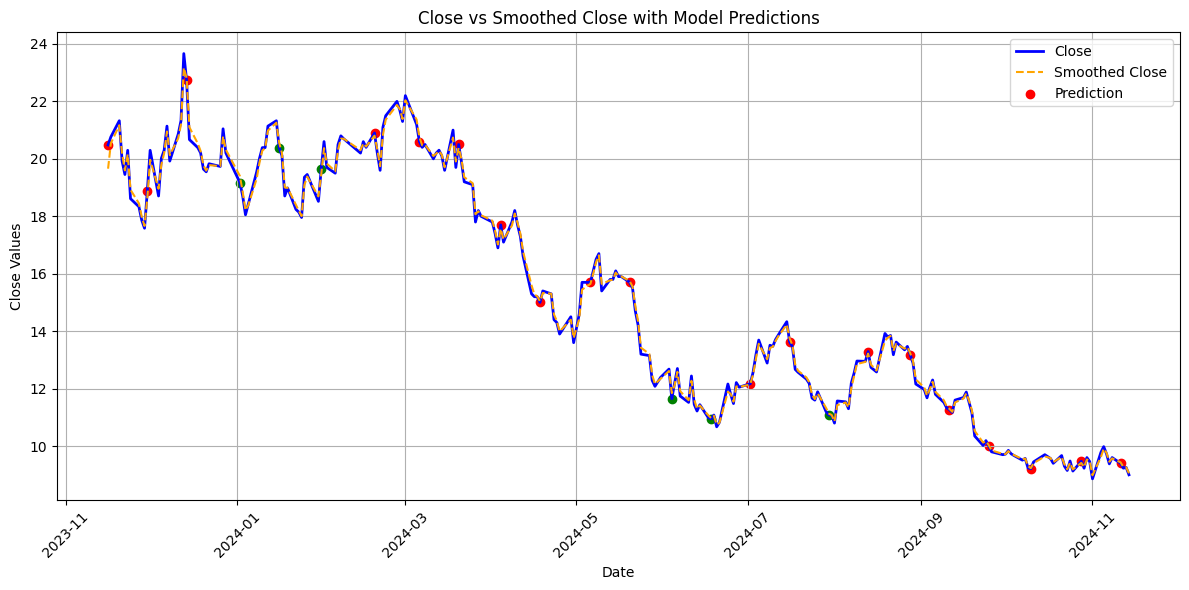

In [155]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Magalu.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [156]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
11765,2000-01-20,5.313,5.313,5.313,5.313,1.157734,26268160000,PETR4.SA,-0.012,5.316806,1.0,5.313,1.0,6.181,6.144533,0.012,0.000,27.170336,5.313,5.875,0.677123,-99.322877,-0.035180,-0.053013,-0.032733,-186288640000,1
11766,2000-01-21,5.200,5.200,5.200,5.200,1.133111,17512960000,PETR4.SA,-0.113,5.223361,1.0,5.200,1.0,6.399,6.348107,0.113,0.000,20.428414,5.200,5.613,5.656455,-94.343545,-0.042136,-0.050838,-0.065546,-203801600000,1
11767,2000-01-24,5.163,5.163,5.163,5.163,1.125048,18385920000,PETR4.SA,-0.037,5.175072,1.0,5.163,1.0,6.213,6.240021,0.037,0.000,18.677468,5.163,5.613,2.682706,-97.317294,-0.049814,-0.050633,-0.058727,-222187520000,1
11768,2000-01-26,5.225,5.225,5.225,5.225,1.138559,25917440000,PETR4.SA,0.062,5.215014,1.0,5.225,1.0,5.813,5.898404,0.000,0.062,30.238440,5.163,5.613,11.558732,-88.441268,-0.052579,-0.051022,-0.049394,-196270080000,1
11769,2000-01-27,5.188,5.188,5.188,5.188,1.130496,38379520000,PETR4.SA,-0.037,5.193403,1.0,5.188,1.0,5.888,5.890081,0.037,0.000,27.542316,5.163,5.613,6.756210,-93.243790,-0.055414,-0.051901,-0.030575,-234649600000,1


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [157]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.55
Fold 2:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.45
Fold 3:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.47
Fold 4:
  Accuracy with Y_test (Prediction): 0.57
  Accuracy with Verify: 0.54
Fold 5:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.53

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.54
  Média da acurácia com Verify: 0.51

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0    -1.0
1           -1.0             -1.0    -1.0
2            1.0             -1.0    -1.0
3           -1.0             -1.0    -1.0
4           -1.0             -1.0    -1.0
...          ...              ...     ...
5010         1.0             -1.0    -1.0
5011         1.0             -1.0    -1.0
5012         1.0             -1.0    -1.0
5013        -1.0             -1.0    -1.0
5014        -1.0    

#### Plotagem Time-Series Cross Validation

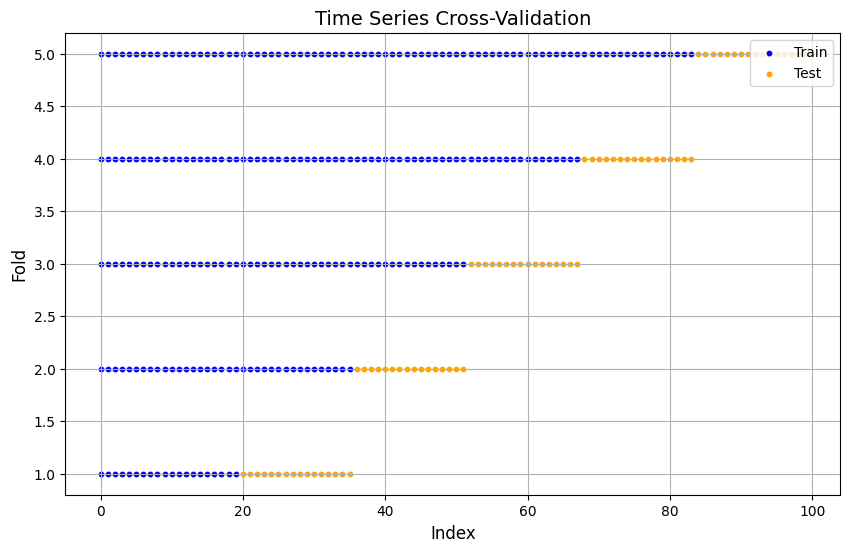

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Petro):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [158]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [159]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.59
Window 2:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.48
Window 3:
  Accuracy with Y_test (Prediction): 0.38
  Accuracy with Verify: 0.33
Window 4:
  Accuracy with Y_test (Prediction): 0.68
  Accuracy with Verify: 0.66
Window 5:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.49
Window 6:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.53
Window 7:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.50
Window 8:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.56
Window 9:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.54
Window 10:
  Accuracy with Y_test (Prediction): 0.39
  Accuracy with Verify: 0.41
Window 11:
  Accuracy with Y_test (Prediction): 0.26
  Accuracy with Verify: 0.22
Window 12:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.56
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [160]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.600000,0.907895,0.722513,76.000000
Up Day,0.892308,0.557692,0.686391,104.000000
accuracy,0.705556,0.705556,0.705556,0.705556
macro avg,0.746154,0.732794,0.704452,180.000000
weighted avg,0.768889,0.705556,0.701642,180.000000


Accuracy: 0.7055555555555556
Precision: 0.8923076923076924
Recall: 0.5576923076923077
Specificity: 0.9078947368421053


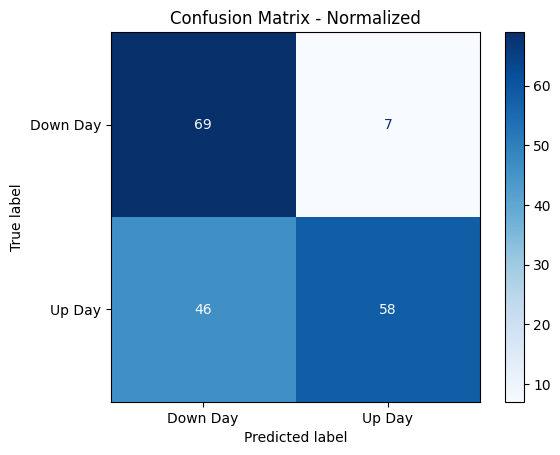

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


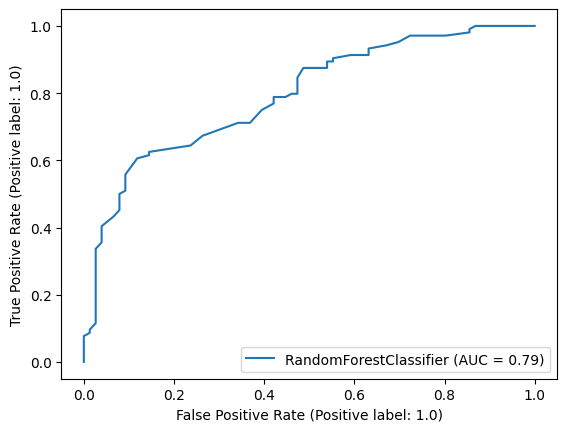

In [162]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Split normal sem cross-validation.

In [163]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [164]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  77.49003984063745


In [165]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.766436,0.684699,0.723265,647.0000
Up Day,0.780172,0.842841,0.810297,859.0000
accuracy,0.774900,0.774900,0.774900,0.7749
macro avg,0.773304,0.763770,0.766781,1506.0000
weighted avg,0.774271,0.774900,0.772907,1506.0000


#### Salvar modelo aprendido para Petrobras.

In [166]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [167]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 87.16%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

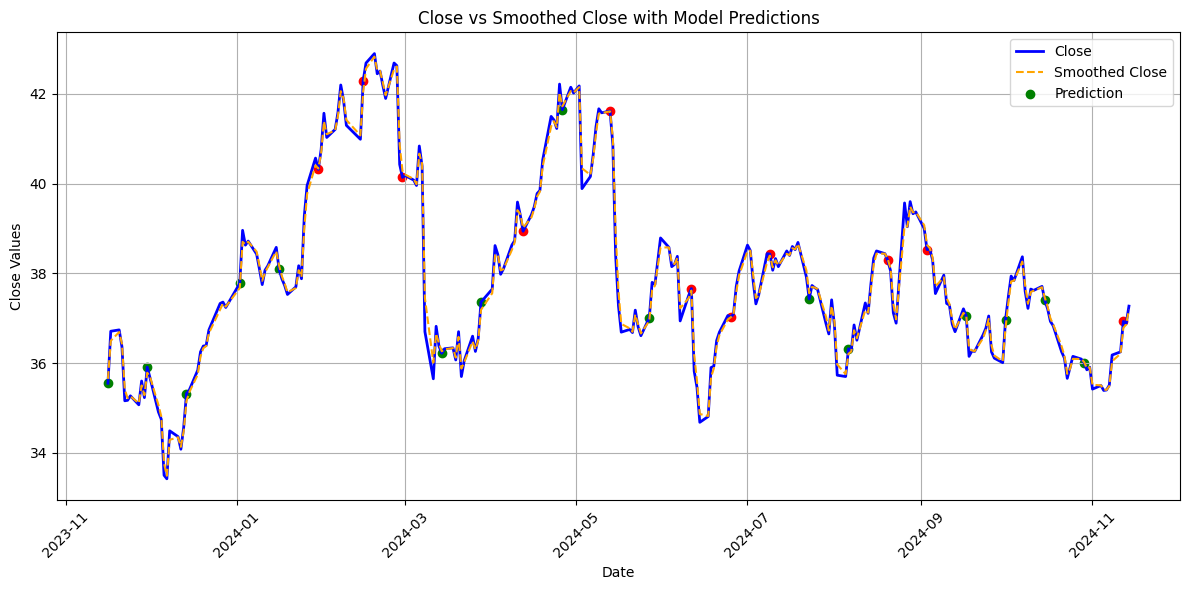

In [168]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Petro.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [169]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5748,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.668742,144000,VALE3.SA,-0.083334,3.934633,1.0,3.916666,-1.0,3.024166,3.027628,0.083334,0.000000,55.357618,3.375000,4.166666,70.690529,-29.309471,0.052577,0.037094,0.043632,8409600,0
5749,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.690045,196800,VALE3.SA,0.050000,3.960259,-1.0,3.966666,-1.0,2.833333,2.872192,0.000000,0.050000,60.156173,3.375000,4.166666,73.927558,-26.072442,0.048145,0.039304,0.034724,8606400,1
5750,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.704248,211200,VALE3.SA,0.033334,3.992052,-1.0,4.000000,-1.0,2.921666,2.911771,0.000000,0.033334,63.199074,3.375000,4.166666,77.943457,-22.056543,0.046104,0.040664,0.031857,8817600,1
5751,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.668742,148800,VALE3.SA,-0.083334,3.931743,-1.0,3.916666,-1.0,2.975000,2.962354,0.083334,0.000000,51.789901,3.458333,4.166666,66.834409,-33.165591,0.040244,0.040580,-0.012231,8668800,1
5752,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.597732,739200,VALE3.SA,-0.166666,3.786349,-1.0,3.750000,-1.0,3.041666,3.025804,0.166666,0.000000,36.559368,3.750000,4.166666,8.723687,-91.276313,0.026095,0.037683,-0.068034,7929600,1


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [170]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.38
  Accuracy with Verify: 0.39
Fold 2:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.52
Fold 3:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.49
Fold 4:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.47
Fold 5:
  Accuracy with Y_test (Prediction): 0.49
  Accuracy with Verify: 0.48

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.49
  Média da acurácia com Verify: 0.47

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0              1.0     1.0
1           -1.0              1.0     1.0
2           -1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4970         1.0             -1.0    -1.0
4971         1.0             -1.0    -1.0
4972         1.0             -1.0    -1.0
4973         1.0              1.0    -1.0
4974        -1.0    

#### Plotagem Time-Series Cross Validation

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Vale):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [171]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [172]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.54
Window 2:
  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.58
Window 3:
  Accuracy with Y_test (Prediction): 0.42
  Accuracy with Verify: 0.45
Window 4:
  Accuracy with Y_test (Prediction): 0.33
  Accuracy with Verify: 0.32
Window 5:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.71
Window 6:
  Accuracy with Y_test (Prediction): 0.71
  Accuracy with Verify: 0.72
Window 7:
  Accuracy with Y_test (Prediction): 0.44
  Accuracy with Verify: 0.39
Window 8:
  Accuracy with Y_test (Prediction): 0.78
  Accuracy with Verify: 0.77
Window 9:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.51
Window 10:
  Accuracy with Y_test (Prediction): 0.72
  Accuracy with Verify: 0.67
Window 11:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.54
Window 12:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.59
Window 13:
  Accuracy wit

#### Outras métricas de acurácia.

In [173]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.750000,0.029126,0.056075,103.000000
Up Day,0.431818,0.987013,0.600791,77.000000
accuracy,0.438889,0.438889,0.438889,0.438889
macro avg,0.590909,0.508070,0.328433,180.000000
weighted avg,0.613889,0.438889,0.289092,180.000000


Accuracy: 0.4388888888888889
Precision: 0.4318181818181818
Recall: 0.987012987012987
Specificity: 0.02912621359223301


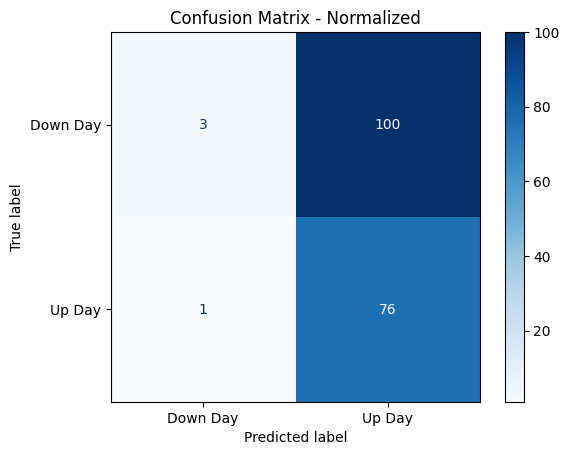

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


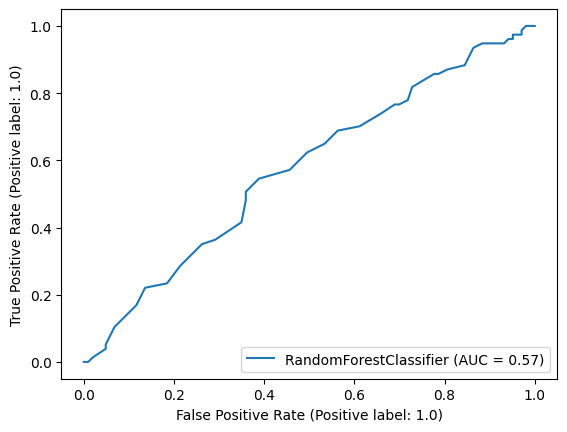

In [175]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Split normal sem cross-validation.

In [176]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [177]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  77.30923694779116


In [178]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.739703,0.712698,0.725950,630.000000
Up Day,0.795941,0.817130,0.806396,864.000000
accuracy,0.773092,0.773092,0.773092,0.773092
macro avg,0.767822,0.764914,0.766173,1494.000000
weighted avg,0.772227,0.773092,0.772473,1494.000000


#### Salvar modelo aprendido para Vale.

In [179]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [180]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 87.14%

Precisão do modelo nos últimos 30 dias: 86.96%


#### Plotagem:

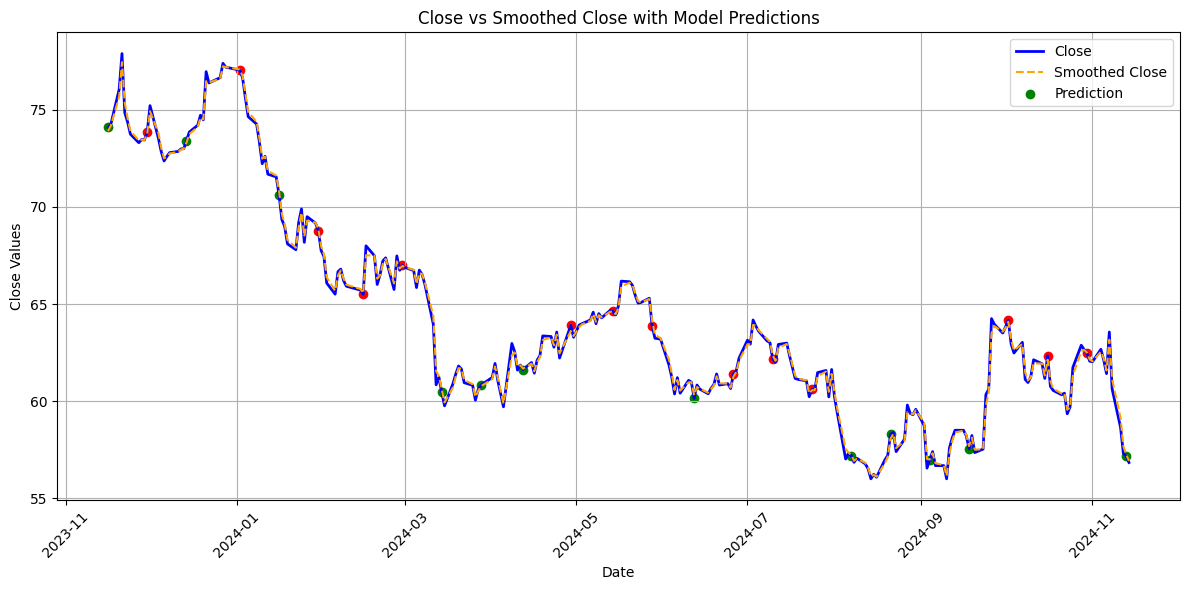

In [181]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Vale.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
